In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor
import os

from src.data.data_processing import *
from src.data.data_fetching import *

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [3]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


# Benchmark Models
Try other models to compare to LSTM for Shasta Reservoir.

## Data Processing
Create train/val/test split. Add five autoregressive lags as columns.

In [28]:
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

In [14]:
def create_lags(df, n_lags, exclude_list):
    """ 
    Add autoregressive lags as columns to a dataframe
    Params:
    df: pandas df, input data
    n_lags: int
    exclude_list: list, str of column names to not create lags for
    """
    df = df.copy()
    for column in df.columns:
        if column in exclude_list:
            continue
        for lag in range(n_lags):
            df[f'{column}_lag{lag+1}'] = df[column].shift(lag)
    return df

In [40]:
class processing_pipeline_w_lags:
    """
    Run data processing pipeline:
    1. Add autoregressive lags
    2. Conduct train/val/test split
    3. Fill NA with training mean
    4. Standardize data with training stats
    """
    def __init__(self, df, n_lags, exclude_list, train_frac=0.6, val_frac=0.2, test_frac=0.2, left_year=1944, right_year=2022):
        """ 
        Params:
        df: pandas df, input data
        *params for create_lags()
        *params for train/val/test split
        left_year: int, year for left data window (1944 for Shasta)
        right_year: int, year for right data window (2022 by default)
        """
        self.df = df # Store original data
        self.n_lags = n_lags
        self.exclude_list = exclude_list
        self.train_frac = train_frac
        self.val_frac = val_frac
        self.test_frac = test_frac
        self.left_year = left_year
        self.right_year = right_year
        self.df_lagged = None # Store df with added lags
        self.scaler = StandardScaler()
        
        # Store processed data
        self.df_train = None
        self.df_val = None
        self.df_test = None
        return
    
    def process_data(self):
        # Add lags
        self.df_lagged = create_lags(df, n_lags=self.n_lags, exclude_list=self.exclude_list)
        # Trim leading NA due to creating lags
        self.df_lagged = self.df_lagged[f'{self.left_year}-01-0{self.n_lags}':f'{self.right_year}-12-31']

        # Train / val / test split
        df_train, df_val, df_test = train_val_test(data=self.df_lagged, train_frac=self.train_frac, val_frac=self.val_frac, test_frac=self.test_frac)

        # Fill NA with training mean
        df_train = df_train.fillna(df_train.mean())
        df_val = df_val.fillna(df_train.mean())
        df_test = df_test.fillna(df_train.mean())

        # Standardize data
        df_train = self.scaler.fit_transform(df_train)
        df_val = self.scaler.transform(df_val)
        df_test = self.scaler.transform(df_test)

        # Save and return results
        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test
        return df_train, df_val, df_test

In [57]:
def plot_lagged_model(model, X_train, X_val, X_test, y_train, y_val, y_test, datetime_index, ax, text_ypos, alpha=1):
    """ 
    Plot true and predicted labels for the entire dataset (train + val + test), as well as calculate and display R2 metrics for each
    Params:
    model -- sklearn model of interest
    X_train/X_val/X_test -- input data of shape (# timesteps, # features)
    y_train/y_val/y_test -- target data of shape (# timesteps, 1)
    datetime_index -- datetime index for ENTIRE DATASET
    ax -- matplotlib axes to plot on
    text_ypos -- y coordinate to print r2 measure on plot
    alpha -- plotting transparency
    Returns:
    (r2_train, r2_val, r2_test) -- tuple of r2 metrics for the train, val, and test sets
    """
    # Get predictions
    y_hat_train, y_hat_val, y_hat_test = model.predict(X_train), model.predict(X_val), model.predict(X_test)

    # Get length of training/val/test datasets
    train_len, val_len, test_len = len(y_train), len(y_val), len(y_test)

    # Find R2 metrics
    r2_train = r2_score(y_pred=y_hat_train, y_true=y_train)
    r2_val = r2_score(y_pred=y_hat_val, y_true=y_val)
    r2_test = r2_score(y_pred=y_hat_test, y_true=y_test)
    metrics = (r2_train, r2_val, r2_test)

    # Concat results, check dimensions with datetime index
    y_hat, y = np.concatenate((y_hat_train, y_hat_val, y_hat_test)), np.concatenate((y_train, y_val, y_test))
    assert len(datetime_index) == len(y_hat) == len(y)

    # Plot
    ax.plot(datetime_index, y, label='observed', alpha=alpha)
    ax.plot(datetime_index, y_hat, label='predicted', alpha=alpha)
    ax.set_xlabel('Datetime')
    ax.set_ylabel('Scaled releases')
    ax.legend()
    # label training/val/test sets and their respective r2
    ax.axvline(x=datetime_index[train_len - 1], linestyle='--', color='black', alpha=alpha)
    ax.text(x=datetime_index[train_len], y=text_ypos, s=f'Training data: $R^2={round(r2_train, 2)}$ ', ha='right', va='top', size='large')

    ax.axvline(x=datetime_index[train_len + val_len - 1], linestyle='--', color='black', alpha=alpha)
    ax.text(x=datetime_index[train_len + val_len - 1], y=text_ypos, s=f'Validation data: $R^2={round(r2_val, 2)}$ ', ha='right', va='top', size='large')

    ax.axvline(x=datetime_index[train_len + val_len + test_len - 1], linestyle='--', color='black', alpha=alpha)
    ax.text(x=datetime_index[train_len + val_len + test_len - 1], y=text_ypos, s=f'Test data: $R^2={round(r2_test, 2)}$ ', ha='right', va='top', size='large')

    return metrics

In [41]:
# Run data processing pipeline
pipeline = processing_pipeline_w_lags(df=df, n_lags=5, exclude_list=['outflow', 'storage', 'doy'])
df_train, df_val, df_test = pipeline.process_data()

In [76]:
pipeline.scaler.feature_names_in_

array(['inflow', 'outflow', 'storage', 'doy', 'inflow_lag1',
       'inflow_lag2', 'inflow_lag3', 'inflow_lag4', 'inflow_lag5'],
      dtype=object)

In [78]:
# Separate features (X) and targets (y)
X_train, X_val, X_test = df_train[:, np.r_[0, 3:9]], df_val[:, np.r_[0, 3:9]], df_test[:, np.r_[0, 3:9]]
y_train, y_val, y_test = df_train[:, 1], df_val[:, 1], df_test[:, 1]

## Fit Models

### Linear Model

In [79]:
# Train model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

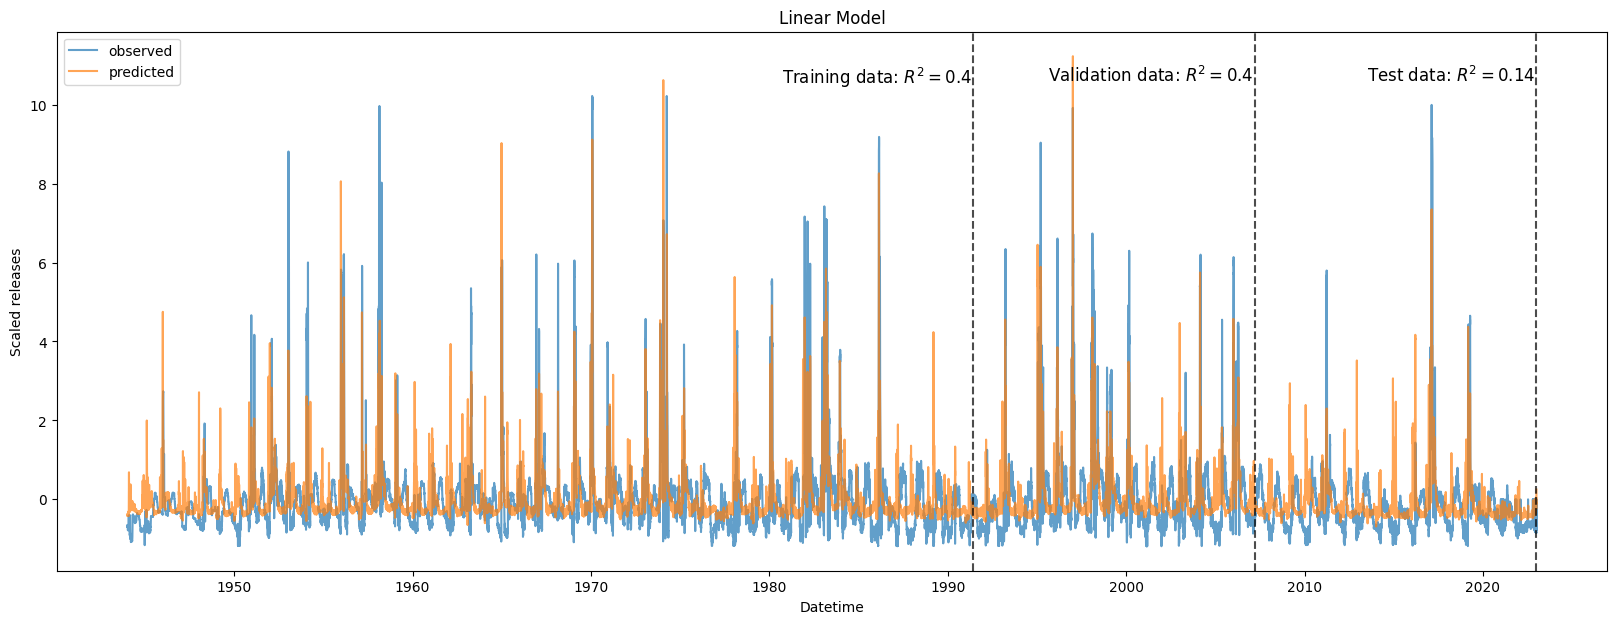

In [82]:
# Plot results
fig, ax = plt.subplots(figsize=(20, 7))
plot_lagged_model(model=linear_model, X_train=X_train, X_val=X_val, X_test=X_test,
                  y_train=y_train, y_val=y_val, y_test=y_test, datetime_index=pipeline.df_lagged.index, 
                  ax=ax, text_ypos=11, alpha=0.7)
ax.set_title('Linear Model')
plt.show()

### Random Forest Model

In [93]:
# Train a model
rf_model = RandomForestRegressor(max_depth=5)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5)

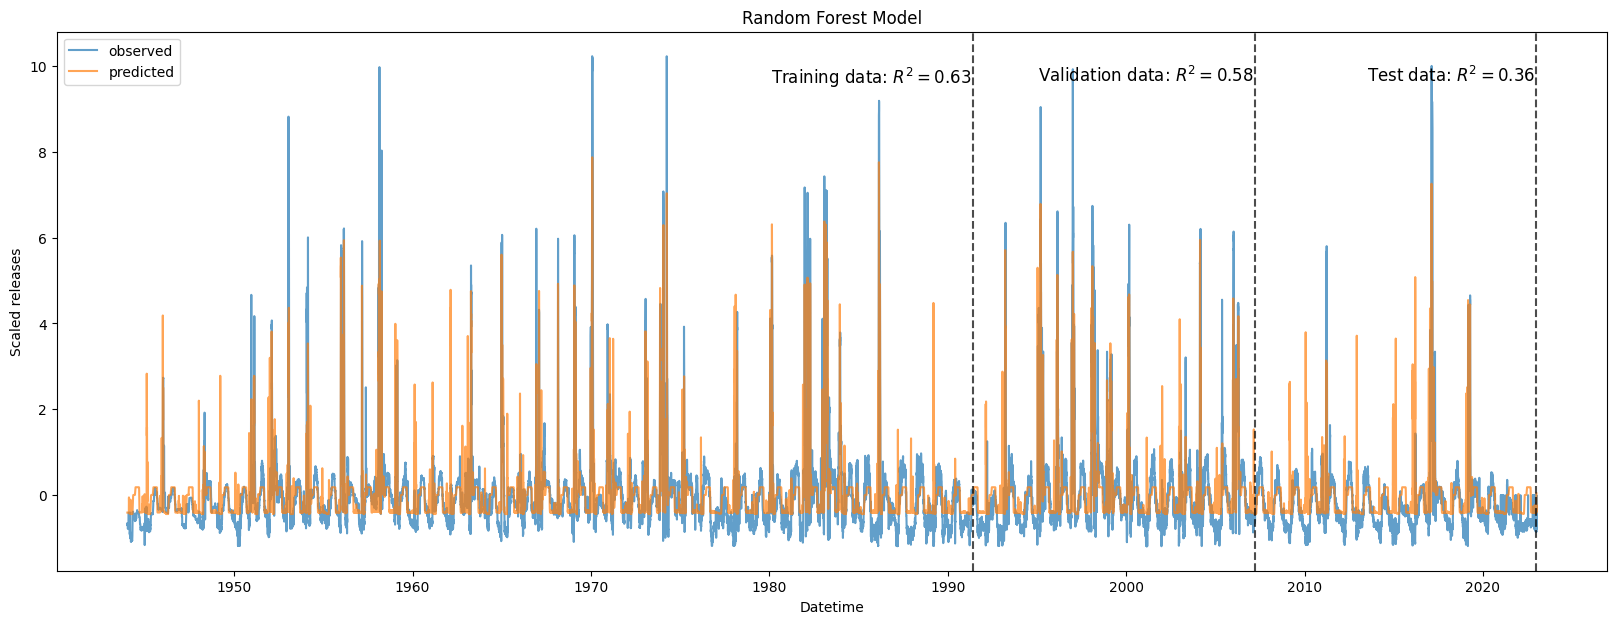

In [94]:
fig, ax = plt.subplots(figsize=(20, 7))
plot_lagged_model(model=rf_model, X_train=X_train, X_val=X_val, X_test=X_test,
                  y_train=y_train, y_val=y_val, y_test=y_test, datetime_index=pipeline.df_lagged.index, 
                  ax=ax, text_ypos=10, alpha=0.7)
ax.set_title('Random Forest Model')
plt.show()

Both the linear model and the random forest model tend to overpredict the number of peaks compared to the LSTM models.

## What if storage information is known?

In [117]:
# Separate features (X) and targets (y)
X_train_stg, X_val_stg, X_test_stg = df_train[:, np.r_[0, 2:9]], df_val[:, np.r_[0, 2:9]], df_test[:, np.r_[0, 2:9]]
y_train_stg, y_val_stg, y_test_stg = df_train[:, 1], df_val[:, 1], df_test[:, 1]

### Linear Model (known storage)

In [118]:
linear_model_stg = LinearRegression()
linear_model_stg.fit(X_train_stg, y_train_stg)

LinearRegression()

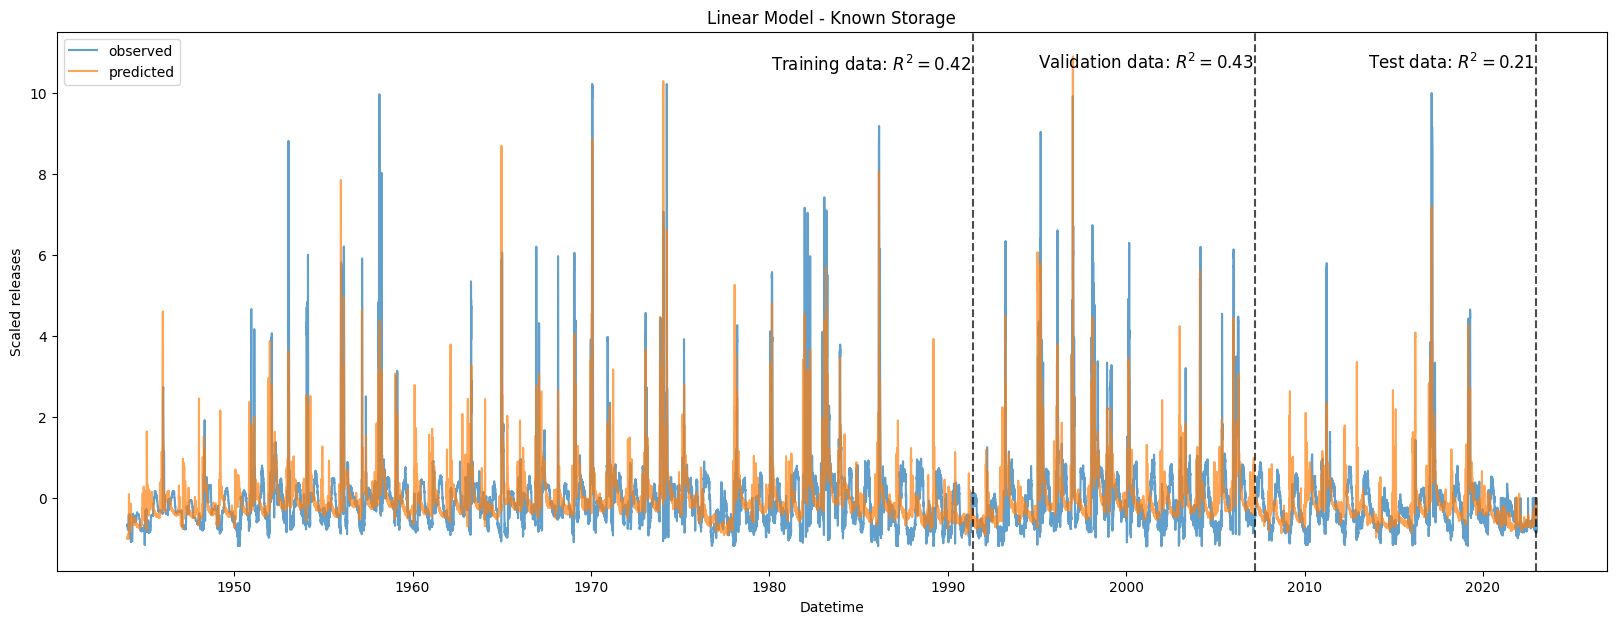

In [121]:
# Plot results
fig, ax = plt.subplots(figsize=(20, 7))
plot_lagged_model(model=linear_model_stg, X_train=X_train_stg, X_val=X_val_stg, X_test=X_test_stg,
                  y_train=y_train_stg, y_val=y_val_stg, y_test=y_test_stg, datetime_index=pipeline.df_lagged.index, 
                  ax=ax, text_ypos=11, alpha=0.7)
ax.set_title('Linear Model - Known Storage')
plt.show()

### Random Forest (Known Storage)

In [120]:
rf_model_stg = RandomForestRegressor(max_depth=5)
rf_model_stg.fit(X_train_stg, y_train_stg)

RandomForestRegressor(max_depth=5)

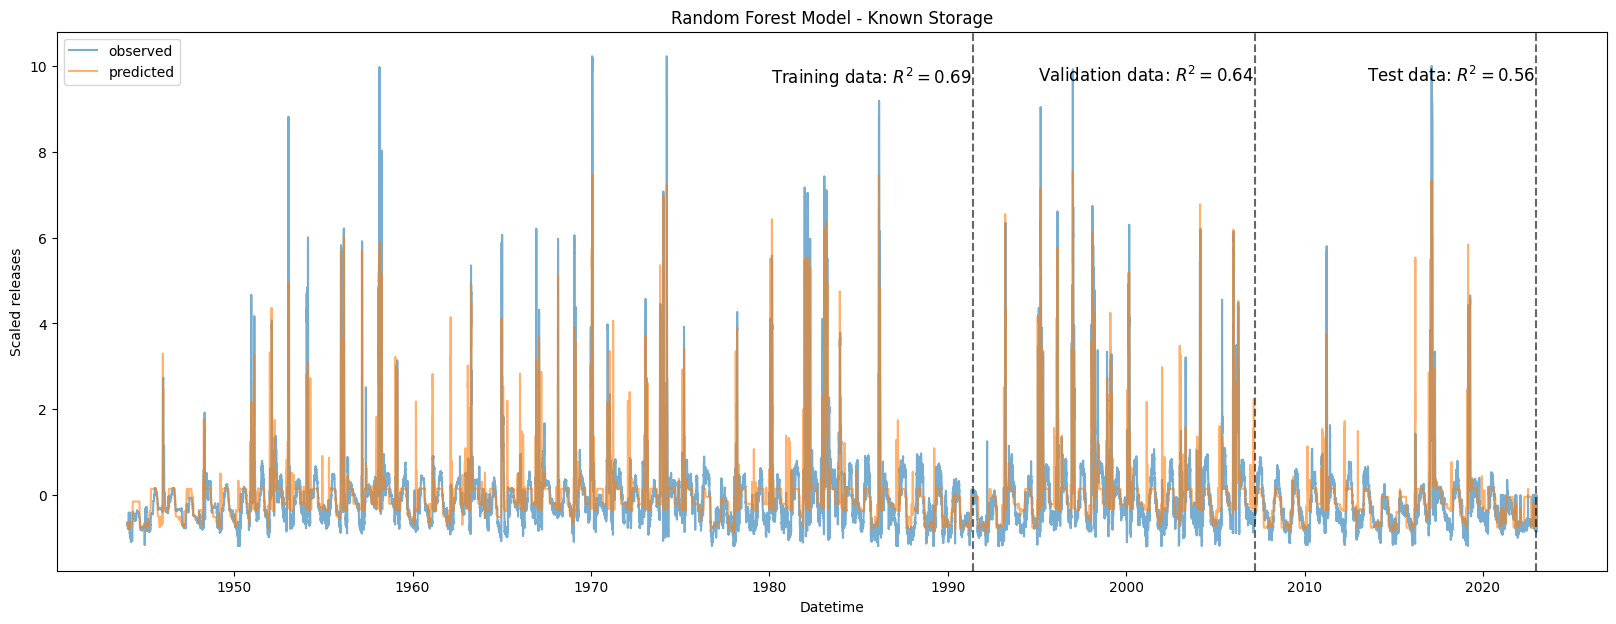

In [123]:
fig, ax = plt.subplots(figsize=(20, 7))
plot_lagged_model(model=rf_model_stg, X_train=X_train_stg, X_val=X_val_stg, X_test=X_test_stg,
                  y_train=y_train_stg, y_val=y_val_stg, y_test=y_test_stg, datetime_index=pipeline.df_lagged.index, 
                  ax=ax, text_ypos=10, alpha=0.6)
ax.set_title('Random Forest Model - Known Storage')
plt.show()

There is a notable improvement, especially for the random forest model. The seasonal releases appear to have adapted to the available storage.